In [1]:
%reload_ext autoreload
%autoreload 
#%reload_ext line_profiler

#from fastai import * 
from fastai.text import * 
import sentencepiece as spm
import io

from fastai_sentencepiece import *
from filetokenizer import *
from languagemodelloader import *

In [2]:
lang            = "en"
pathData       = Path("../nlp-data")
path           = pathData / lang
pathTrainValid = path/"wiki-train_valid"
pathToks       = pathTrainValid/"toks"
spCache        = "sp-model"
pathSPVocab    = pathTrainValid / spCache

# Data preparation

Load the training and validation data we prepared in wiki_preparation.ipynb. In total 100 million articles with a split of 80% / 20% for training/validation:
- First column: text content to train the model. 
- Second column: Boolean representing if the data is for training or validation.

# Create Tokenizer
The sentencepiece vocabulary was trained in Train Sentencepiece tokenizer.ipynb.

Here we will make a BasicTokenizer from Sentencepiece so that fastai can use it instead of spacy

In [3]:
spt_func  = partial(SentencepieceTokenizer.create, path=pathTrainValid, cache_name='sp-model')
spt_func.__name__ = SentencepieceTokenizer.__name__
spt       = spt_func(lang="en")
tokenizer = Tokenizer(spt_func,"en")

pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab  = spt.vocab(), len(spt.vocab().itos)

print(tokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
sentence = ["She is tall.", "He is small"]
tokenizer._process_all_1(sentence)

print("vocab:",vocab)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]
vocab: <fastai.text.transform.Vocab object at 0x1067d0c18>


# LM Training


In [4]:
#Discard section with kess than "minTok" tokens
minToks = 7

In [5]:
pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer = FileTokenizer(pathToks/"train", spt_func,"en",vocab)
validTokenizer = FileTokenizer(pathToks/"valid", spt_func,"en",vocab)

print(trainTokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
#sentence = ["She is tall.", "He is small"]
#tokenizer._process_all_1(sentence)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - rm_extra_lineshift
 - rm_extra_lineshift
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]


In [6]:
from filetokenizer import *
#import timeit start = timeit.default_timer()
pathTxt = pathTrainValid/"txt"
files   = np.asarray( list(pathTxt.glob("*.txt")) )
nrows   = len(files)
split   = 0.2
splitindex, index = int(nrows*split+.5), np.random.permutation(np.arange(nrows)) 

chunksize=0

trainList = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=trainTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)],
                      minToks=minToks)

validList = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=validTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)],
                      minToks=minToks)
#print(timeit.default_timer()-start )

In [7]:
if not (pathToks/"train").exists():
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    %time trainList.process()
    trainList=None
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [8]:
if not (pathToks/"valid").exists():
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    %time p = validList.process()
    validList=None
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [9]:
print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
%time trainIDS = trainTokenizer.getIds()

1 nb: used GB memory: 5.56
threading with on 1 cores
CPU times: user 1min 43s, sys: 9.73 s, total: 1min 52s
Wall time: 1min 54s


In [10]:
%time validIDS=validTokenizer.getIds()
print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

threading with on 1 cores
CPU times: user 32.6 s, sys: 4.35 s, total: 36.9 s
Wall time: 37.7 s
2 nb: used GB memory: 8.82


Traning:    number of arrays:24871686 - number of ids:2044746556
Validation: number of arrays:8310438 - number of ids:732773770
Lenght of token rags min:5 max:12985 - median:65.0
865863


array([134,  71,  70,  16,  35,  39, 269, 261, 146,  89,  39,  43,  42,  20,  33, 132,  87,  67,  12,  36], dtype=int32)

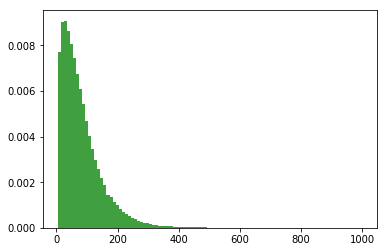

In [11]:
print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{np.sum([len(ids) for ids in trainIDS])}")
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{np.sum([len(ids) for ids in validIDS])}")

#Analyse the distribution of the legnth of tokens sequences in the ragged/jagged array of tokes
sectionlengths   = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
plt.hist(sectionlengths[sectionlengths<1000], 100, density=True, facecolor='g', alpha=0.75)
np.histogram(sectionlengths[sectionlengths<1000],50)

print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
print("sectionlengths<10:", np.sum(sectionlengths<10))
sectionlengths[:20]

In [12]:
#i have an issue with passing pad_idx
#dblm = MyTextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS[0:3000], validIDS[0:600], bs=128)
dblm = MyTextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS[0:1000], validIDS[0:200], bs=32)
#dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS[0:1000], validIDS[0:200], bs=32)

MyTextLMDataBunch def create
train_ds <class 'fastai.data_block.LabelList'>
valid_ds <class 'fastai.data_block.LabelList'>
datasets
0 ds:<class 'fastai.data_block.LabelList'>
1 ds:<class 'fastai.data_block.LabelList'>
2 ds:<class 'fastai.data_block.LabelList'>
LanguageModelLoader.__init__ Used GB memory:10.48 batches:24 nToks:53367 bptt:70 p_bptt:0.95 shuffle:True backwards:False
LanguageModelLoader.__init__ Used GB memory:10.48 batches:10 nToks:21795 bptt:70 p_bptt:0.95 shuffle:False backwards:False
LanguageModelLoader.__init__ Used GB memory:10.48 batches:24 nToks:53367 bptt:70 p_bptt:0.95 shuffle:False backwards:False


In [13]:
len(dblm.train_ds.vocab.itos)

32000

In [14]:
dblm.show_batch()

LanguageModelLoader.allocate_buffers Used GB memory:10.46 shuffle:True backwards:False


idx,text
0,"▁pri mic er io ▁( born ▁13 ▁1940 ▁in ) ▁is ▁an ▁politician , ▁former ▁mayor ▁of . ▁members ▁of ▁ch lor oc y st ini ▁are ▁found ▁primarily ▁in ▁southeast , stral as ia , ▁and ▁the ▁western . xxup ▁i sol ated ▁genera ▁occur ▁in , ▁south , ▁the car ene ▁islands , ▁and it ius"
1,. ▁made ▁an ▁agreement ▁with xxup ▁r ana ▁rulers ▁of ▁to ▁construct ▁dam ▁in ▁sun s ari ▁and ▁sap t ari ▁districts ▁of ▁but ▁the ▁project ▁failed ▁after ▁the ▁flood ▁of ▁may ▁1891 . ▁on ▁27 ▁1897 ▁prime ▁minister sher xxup ▁r ana ▁approved ▁to ▁construct ▁a ▁dam ▁below ▁bar a ha xxup ▁k she tra . ▁again ▁in ▁1944 ▁an
2,"ssel a er ▁institute , ▁a ▁master ' s ▁degree ▁in ▁engineering ▁management , ▁and ▁an xxup ▁in ▁marketing , ▁finance ▁and ▁organizational ▁behavior ▁from ▁northwestern ▁university . ▁unit é xxup ▁1 -2 ▁ru kin zo xxup ▁at ▁level ▁he ▁won ▁a ▁title ▁in ▁bog ota ▁in ▁1992 ▁and ▁the ▁same ▁year ▁had ▁a ▁win ▁over ▁pat xxup ▁r after ▁at ▁the xxup ▁s"
3,"▁among ▁them ▁"" xxmaj cur rier ▁& xxup ▁i ves ▁and ▁the ▁new ▁scene "" ▁and ▁"" xxmaj we ▁cover ▁the ▁new er ."" ▁in ▁1934 ▁she ▁organized ▁the ▁first ▁important en ice ▁show ▁in ▁the ▁united ▁states . ▁her ▁exhibition ▁of ▁the ▁work ▁of xxup ▁a . is , ▁in ▁1947, ▁re dis covered ▁the ▁pioneer ▁social ▁document arian ▁and ▁gained ▁his ▁collection"
4,"▁of ▁his ▁mother ’ s ▁parents , ▁who ▁survived ▁the ▁war . ▁in ▁1950, ▁he ▁immigrated ▁to ▁with ▁his ▁mother . ▁after ▁spending ▁one ▁and ▁a ▁half ▁years ▁in ▁an ▁immigrant ▁camp ▁and ▁the a ▁refugee ▁absorption ▁camp ▁( ma ` a bara ), ▁they ▁moved ▁to fa . ▁in ▁1955, ▁la ub ▁began ▁studying ▁medicine ▁at ▁the ▁university ▁of ’ s ▁had assa h"


In [15]:
print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
%time learn = language_model_learner(dblm, drop_mult=0, qrnn=False, pad_token=-1, callback_fns=ShowGraph)
print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

1 nb: used GB memory: 10.45
CPU times: user 489 ms, sys: 56.8 ms, total: 546 ms
Wall time: 546 ms
2 nb: used GB memory: 10.42


1 nb: gc.collect:7445 - used GB memory:10.07


epoch,train_loss,valid_loss,accuracy
1,9.325174,7.754635,0.079508
2,7.847447,7.035449,0.039692
3,7.266937,7.039110,0.069600
4,6.951165,6.885926,0.084526
5,6.706802,6.843150,0.084384
6,6.476172,6.747453,0.087649
7,6.259542,6.709064,0.107559
8,6.050869,6.688700,0.117316
9,5.873759,6.688754,0.113544
10,5.746704,6.735076,0.116573


LanguageModelLoader.allocate_buffers Used GB memory:6.68 shuffle:False backwards:False


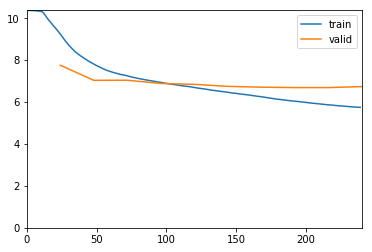

CPU times: user 1h 49min 32s, sys: 5min 56s, total: 1h 55min 28s
Wall time: 32min 3s
2 nb: gc.collect:1324 - used GB memory:7.93


In [16]:
print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
%time learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))
print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [17]:
learn.save('model-32k-sentencepiece-vocab')